In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

# 1. Dataset
#### Problem
- Train a character base Language model to generate new dinosaur names based on existing name in `data`

In [3]:
with open('datasets/dinos.txt', 'r+') as file_obj:
    data = file_obj.readlines()
data = [ dino.strip().lower() for dino in data ]

print(len(data))
print(data[:5])

1536
['aachenosaurus', 'aardonyx', 'abdallahsaurus', 'abelisaurus', 'abrictosaurus']


# 2. Feat Engineering
## 2.1 Lexicon - Vocab

In [4]:
chars = sorted(list(set(''.join(data)))) + ['\n']
print(chars)

vocab_size = len(chars)
print(f'Vocab size of the character-based language model: {vocab_size}')

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\n']
Vocab size of the character-based language model: 27


#### Char to index

In [5]:
char_2_ix = { ch:ix for ix,ch in enumerate(chars)}
print(char_2_ix)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '\n': 26}


#### index to char

In [6]:
ix_2_char = { ix:ch for ix,ch in enumerate(chars) }
print(ix_2_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '\n'}


# 2.2 Training tensor
#### X tensor

In [7]:
def generate_X_tensor(word, char_2_ix):
    """
    Arguments:
        word (str)                : Input string/word
        char_2_ix (dict({ch:ix})) : mapping characters in lexicon to its index
    Returns:
        X (tensor(n_x, 1, T_x))    : tensor X, lexicon one-hot vector to train RNN
            n_x     : featdim = lexicon size
            m = 1   : batchsize = 1
            T_x     : total timesteps = len(word)
    """
    # Get vocab size
    vocab_size = len(char_2_ix)

    # Generate X
    X_np = np.zeros(shape=(vocab_size, 1, len(word)), dtype=np.float32)
    for t, ch in enumerate(word):
        X_np[char_2_ix[ch], 0, t] = 1

    return torch.from_numpy(X_np)

In [8]:
X = generate_X_tensor('harry', char_2_ix)

# (feat_dim, batch_size, Tx)
print(X.size())

torch.Size([27, 1, 5])


#### Y tensor
<img src="./assets/rnn_lm_y.png" width="800"/>

In [9]:
def generate_Y_tensor(word, char_2_ix, eos='\n'):
    """
    Y = predict the next character in the sequence

    Arguments:
        word (str)                : Input string/word
        char_2_ix (dict({ch:ix})) : mapping character-2-index in lexicon
        eos (char)                : End-of-sentence character
    Returns:
        Y (Long tensor(1, T_y))    : tensor Y, lexicon index one-hot vector of the next character in word
            m = 1   : batchsize = 1
            T_y     : total timesteps = len(word)
    Notes:
        nn.NLLLoss()
            Y_hat = one-hot vector
            Y = index of the correct idx in range(0, len(one-hot-vec)), instead of a one-hot vector
    """
    Y_np = np.zeros(shape=(1, len(word)), dtype=np.int32)

    # y = next(idx) char in word
    for t in range(len(word)-1):
        next_ch = word[t+1]
        Y_np[0, t] = char_2_ix[next_ch]

    # Last char to predict = eos char
    Y_np[0, len(word)-1] = char_2_ix[eos]
    return torch.LongTensor(Y_np)

In [10]:
Y = generate_Y_tensor('harry', char_2_ix)

# (batch_size, Ty)
print(Y.size())
print('Y[0] =', Y[0])

torch.Size([1, 5])
Y[0] = tensor([ 0, 17, 17, 24, 26])


# 3. Model


<img src="./assets/rnn_step_forward.png" width="550"/>

In [11]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Arguments:
            Wax (tensor (n_a, n_x)) : input-to-hidden Weight matrix
            Waa (tensor (n_a, n_a)) : hidden-to-hidden Weight matrix
            Wya (tensor (n_y, n_a)) : hidden-to-output Weight matrix
            ba (tensor (n_a, 1))    : Hidden bias vector
            by (tensor (n_y, 1))    : Output Bias vector
        """
        super(RNN, self).__init__()

        # Hidden
        self.Wax = torch.nn.Parameter(
            torch.randn(hidden_dim, input_dim),requires_grad=True)
        self.Waa = torch.nn.Parameter(
            torch.randn(hidden_dim, hidden_dim), requires_grad=True)
        self.ba = torch.nn.Parameter(
            torch.randn(hidden_dim, 1), requires_grad=True)
        self.tanh = nn.Tanh()

        # Out
        self.Wya = torch.nn.Parameter(
            torch.randn(output_dim, hidden_dim), requires_grad=True)        
        self.by = torch.nn.Parameter(
            torch.randn(output_dim, 1), requires_grad=True)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=0)

    def forward(self, xt, a_prev):
        """
        Arguments:
            xt (tensor (n_x, m))        : Input data timestep t
            a_prev (tensor (n_a, m))    : Input hidden state timestep t-1

        Returns:
            a_next (tensor (m, n_a))   : Hidden states timestep t
            y_hat (tensor (m, n_y))    : Predictions timestep t
        """
        a_next = self.tanh(self.Wax @ xt + self.Waa @ a_prev + self.ba)
        y_hat = self.softmax(
            self.dropout(self.Wya @ a_next + self.by)).T
        return y_hat, a_next

# 4. Train

In [12]:
def sample(model, char_2_ix, ix_2_char,
        hidden_dim=128,
        max_length=20, eos='\n', k=1, seed=0,
        device='cpu'):
    """
    Generate a new word based on input model 

    Arguments:
        model (torch model)         : Inference model
        char_2_ix (dict({ch:ix}))   : mapping character-2-index in lexicon
        ix_2_char (dict({ix:ch}))   : mapping index-2-character in lexicon

        hidden_dim (int)            : n_a, model hidden dim
        max_length (int)            : maximum length of the output word
        eos (str)                   : End-of-sentence character
        k (int)                     : number of ouput words
        seed (int)                  : random seed
        device (str)                : Model device

    Returns:
        sampled words (list(str))   : List of model generated words
    """
    # Init
    words = []
    np.random.seed(seed)

    # Generate k words
    for i in range(k):
        # Random init the first letter
        letter = ix_2_char[np.random.randint(0, len(ix_2_char))]
        while letter == eos:
            letter = ix_2_char[np.random.randint(0, len(ix_2_char))]
        word = letter

        # Use model to generate the next char until hitting eos
        with torch.no_grad():
            a = torch.from_numpy(
                np.zeros(shape=(hidden_dim, 1), dtype=np.float32)) \
                    .to(device)
            for i in range(max_length):
                # Inference
                X = generate_X_tensor(letter, char_2_ix).to(device)
                y_hat, a = model(X[:,:,0], a)

                # Get onehot index
                _, idx = y_hat.topk(1)
                idx = int(idx[0][0])

                # Next char, if eos stop
                if ix_2_char[idx] == eos:
                    break
                else:
                    letter = ix_2_char[idx]
                    word += letter
        words.append(word)
    return words

In [13]:
class Trainer(object):
    def __init__(self,
            char_2_ix, ix_2_char,
            hidden_dim=128, alpha=1e-2):
        """
        Arguments:
            char_2_ix (dict({ch:ix}))   : mapping character-2-index in lexicon
            ix_2_char (dict({ix:ch}))   : mapping index-2-character in lexicon

            hidden_dim (int)            : n_a, model hidden dim
            alpha (float)               : learning rate
        """
        # Params
        self.hidden_dim = hidden_dim
        self.alpha = alpha
        
        # Dictionaries
        self.char_2_ix = char_2_ix
        self.ix_2_char = ix_2_char
        
        # Model
        vocab_size = len(char_2_ix)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.rnn_cell = RNN(
            input_dim=vocab_size,
            hidden_dim=hidden_dim,
            output_dim=vocab_size)
        self.criterion = nn.NLLLoss()
        

    def train_word(self, word):
        """
        Train each word

        Arguments:
            word (str)       : Input string/word

        Returns:
            cost_w (float)   : Average character cost from the trained word 
        """
        # Init tensor
        X = generate_X_tensor(word, self.char_2_ix) \
            .to(self.device)
        Y = generate_Y_tensor(word, self.char_2_ix) \
            .to(self.device)
        a = torch.from_numpy(
            np.zeros(shape=(self.hidden_dim, 1), dtype=np.float32)) \
                .to(self.device)
        T = len(word)
        
        # Zero grad
        cost_w = 0
        self.rnn_cell.zero_grad()
                
        # Compute each timestep Forward
        for t in range(T):
            # Foward
            yt_hat, a = self.rnn_cell(X[:,:,t], a)
        
            # Cost
            cost_c = self.criterion(yt_hat, Y[:, t])
            cost_w += cost_c
            
        # Back Propagation
        cost_w.backward()
        for p in self.rnn_cell.parameters():
            p.data.add_(p.grad.data, alpha=-self.alpha)

        # Return cost
        return cost_w.item() / len(word)


    def fit(self, data, num_iters=1000):
        """
        Train RNN cell

        Arguments:
            data (list(str))       : Input list of strings/words
            num_iters (int)        : num of training iterations

        Returns:
            model (torch model)    : Trained RNN cell
            J_history (list(float)): cost history for plotting
        """
        # Init model
        self.rnn_cell.to(self.device)
        self.rnn_cell.train()

        # Init
        J_history = []
        seed = 0

        # Train each iter
        for i in range(num_iters):
            # Train each word from data
            cost_iter = 0
            for word in data:
                cost_w = self.train_word(word)
                cost_iter += cost_w
            cost_iter /= len(data)

            # Log progress
            J_history.append(cost_w)
            if i % 10 == 0 or i == num_iters-1:
                # Show sample words from trained model
                sample_words = sample(
                    self.rnn_cell, self.char_2_ix, self.ix_2_char,
                    hidden_dim=self.hidden_dim,
                    max_length=10, eos='\n', k=5, seed=seed,
                    device=self.device)

                # Print
                print(f"Iteration [{i}] : Cost = {cost_w:.3f} : Sample words = {sample_words}")
    
            # Reseed
            seed += 1 + i
        return self.rnn_cell, J_history

In [14]:
HID_DIM = 16
learning_rate = 0.00045

tn = Trainer(char_2_ix, ix_2_char,
    hidden_dim=HID_DIM,
    alpha=learning_rate)

model, J_hist = tn.fit(data, num_iters=120)

Iteration [0] : Cost = 5.147 : Sample words = ['mdayu', 'pooanuo', 'vaoussrurus', 'aausussruru', 'drayurus']
Iteration [10] : Cost = 3.097 : Sample words = ['noanaus', 'huaus', 'ieanaus', 'fuaus', 'xaaaoss']
Iteration [20] : Cost = 3.246 : Sample words = ['kiooaus', 'huanausaus', 'meoaus', 'fusaus', 'gaoanaus']
Iteration [30] : Cost = 3.321 : Sample words = ['oaosrus', 'ziosrus', 'leosrus', 'vioss', 'zaonanoss']
Iteration [40] : Cost = 3.225 : Sample words = ['ruosauru', 'teosaurus', 'juosaurusa', 'ruonanaurus', 'juosaururau']
Iteration [50] : Cost = 3.221 : Sample words = ['manosaurus', 'erasaurus', 'urosaurus', 'caosauru', 'urosaurus']
Iteration [60] : Cost = 3.037 : Sample words = ['gunosaurus', 'nurananauru', 'sananananau', 'panananauru', 'sanananaura']
Iteration [70] : Cost = 3.011 : Sample words = ['sanon', 'uronananaur', 'hanosaurus', 'xaosaurus', 'veranosauru']
Iteration [80] : Cost = 2.963 : Sample words = ['carasaurus', 'fanosa', 'iranananana', 'xuananosaur', 'tanosaurus']
It

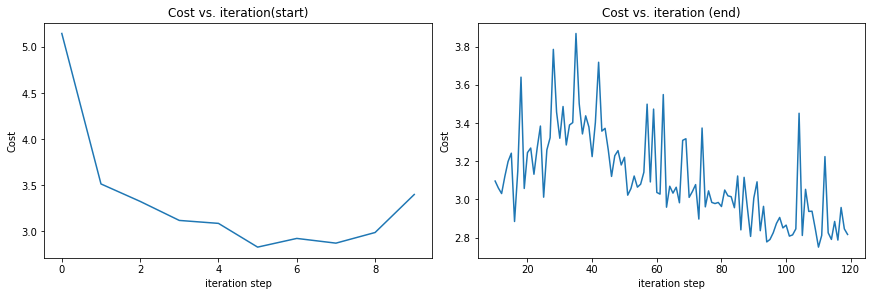

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 5. Inference

In [16]:
model.to('cpu')

for i in range(0,10):
    new_dinos = sample(
        model, char_2_ix, ix_2_char,
        hidden_dim=HID_DIM,
        max_length=20, eos='\n', k=5, seed=i,
        device='cpu')
    print(new_dinos)

['manosaprus', 'panosaurus', 'veranan', 'anosaurus', 'denosaurus']
['fanosausu', 'lanos', 'malosaurus', 'iranan', 'jurosaurusss']
['irananananaura', 'panosaurus', 'neesaurus', 'iranan', 'wanosaurus']
['kanosaurus', 'yuosauru', 'zhonosaurus', 'dinosaurus', 'yuosaurus']
['onosaurus', 'xueranananananaurus', 'fasaurus', 'berosatanan', 'inosausus']
['deranananananaurus', 'onos', 'panasausu', 'ganosauru', 'wanosaurus']
['konos', 'jurosaurus', 'deran', 'urosaurus', 'kanosauruss']
['panosaurur', 'elosausu', 'zhonon', 'wanosauruss', 'deranananauru']
['denosaurus', 'urosax', 'ranosausu', 'jurosaurus', 'fanosaurus']
['veranan', 'wanosaurus', 'yuosaurusss', 'wanosasru', 'banosaurus']
